## Setup and Import

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from joblib import dump, load

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [2]:
churn = pd.read_csv('../data/trunc_churn.csv')
members = pd.read_csv('../data/trunc_members.csv')
transactions = pd.read_csv('../data/trunc_transaction.csv')
users = pd.read_csv('../data/trunc_users.csv')

merged_df = churn.merge(members, on='msno'
         ).merge(transactions, on='msno'
         ).merge(users, on='msno').set_index('msno')

In [3]:
print(churn.shape)        # 20,000 users
print(members.shape)      # 17,600 users
print(transactions.shape) # 19,216 users, each line is a transaction
print(users.shape)        # 15,457 users, each line is a listening session
print(merged_df.shape)           # 148,48 users, each line varies

(20000, 2)
(17660, 6)
(23588, 9)
(277101, 9)
(335947, 22)


## Imputation

In [4]:
# convert missing/junk ages to 0
merged_df.loc[merged_df.bd <= 0, 'bd'] = np.nan
merged_df.loc[merged_df.bd > 100, 'bd'] = np.nan

In [5]:
# numerically encode gender
merged_df.loc[merged_df.gender == 'female', 'gender'] = 1
merged_df.loc[merged_df.gender == 'male', 'gender'] = 0

# convert dtype from object to float for imputer
merged_df.gender = merged_df.gender.astype(float)

In [6]:
merged_df = merged_df.rename(columns={'gender': 'is_female',
                        'bd': 'age',
                        'date': 'listen_date'})

In [7]:
# group merged_df by user for imputing user age and gender
df = merged_df.groupby('msno').mean()

# KNN is distance-based so data must be temporarily scaled
scaler = MinMaxScaler()
scaler_fitted = scaler.fit(df)
scaled_merged_df = pd.DataFrame(scaler_fitted.transform(df),
                         index=df.index, columns=df.columns)

In [8]:
# # impute scaled user-grouped df
# imputer = KNNImputer(n_neighbors=round(np.sqrt(len(merged_df))))
# imputed_array = imputer.fit_transform(scaled_merged_df)
# dump(imputed_array, '../data/imputed_array.pkl')

# undo scaling
imputed_array = load('../data/imputed_array.pkl')
inverse_array = scaler_fitted.inverse_transform(imputed_array)
imputed_merged_df = \
    pd.DataFrame(inverse_array,
                 index=df.index, columns=df.columns)

In [9]:
# classify predictions as female or male using 50% threshold
imputed_merged_df.loc[imputed_merged_df.is_female >= 0.5, 'is_female'] = 1
imputed_merged_df.loc[imputed_merged_df.is_female < 0.5, 'is_female'] = 0

In [10]:
# convert age from float to int
imputed_merged_df.age = imputed_merged_df.age.apply(lambda x: round(x))

In [11]:
# merge imputed columns
merged_df = merged_df.drop(['age', 'is_female'], axis=1
       ).merge(imputed_merged_df[['age', 'is_female']],
         how='left', left_index=True, right_index=True)

## Pre-Processing

In [12]:
date_cols = ['registration_init_time', 'transaction_date',
             'membership_expire_date', 'listen_date']

# change date cols to datetime dtype
for col in date_cols:
    merged_df[col] = pd.to_datetime(merged_df[col], format='%Y%m%d')

In [13]:
categorical_cols = ['city', 'registered_via', 'payment_method_id']
bool_cols = ['is_churn', 'is_auto_renew', 'is_cancel']

# change numeric cols that represent categorical data to object dtype
for col in categorical_cols + bool_cols:
    merged_df[col] = merged_df[col].astype(str)

## Dataframe by User

### Pre-processing:
- Includes 4 engineered features to sub for date cols when grouping by user:
    - num_transactions: sub for transaction_date
    - num_sessions: sub for listen_date
    - membership_duration: sub for registration_init_time
    - days_to_expiration: sub for membership_expire_date

In [14]:
transactions = transactions.set_index('msno')
merged_df['num_transactions'] = \
    transactions.groupby('msno').transaction_date.count()
merged_df.num_transactions.fillna('0', inplace=True)

In [15]:
users = users.set_index('msno')
merged_df['num_sessions'] = \
    users.groupby('msno').date.count()
merged_df.num_sessions.fillna('0', inplace=True)

In [16]:
merged_df['membership_duration'] = \
    (merged_df.membership_expire_date - merged_df.registration_init_time
    ).astype('timedelta64[D]')

In [17]:
merged_df['days_to_expiration'] = \
    (merged_df.membership_expire_date - merged_df.transaction_date
    ).astype('timedelta64[D]')

### Groupby MSNO

In [18]:
df = merged_df.groupby('msno').mean()

single_value_cols = \
    merged_df[categorical_cols + bool_cols].groupby('msno').max()

df = df.merge(single_value_cols, how='left',
              left_index=True, right_index=True);

In [19]:
df.payment_plan_days = round(df.payment_plan_days)

In [20]:
df.rename(columns={
    'payment_plan_days' : 'payment_plan_days_per_transaction_avg',
    'plan_list_price'   : 'plan_list_price_per_transaction_avg',
    'actual_amount_paid': 'actual_amount_paid_per_transaction_avg',
    'num_25' : 'num_25_per_session_avg',
    'num_50' : 'num_50_per_session_avg',
    'num_75' : 'num_75_per_session_avg',
    'num_985': 'num_985_per_session_avg',
    'num_100': 'num_100_per_session_avg',
    'num_unq': 'num_unq_per_session_avg',
    'total_secs': 'total_secs_per_session'}, inplace=True);

## K-Means Clustering

In [21]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaler_fitted.transform(df),
                         index=df.index, columns=df.columns)

For 2 clusters, the average silhouette score is: 0.8118762891290716
For 3 clusters, the average silhouette score is: 0.5253224225118569
For 4 clusters, the average silhouette score is: 0.46352776134167983
For 5 clusters, the average silhouette score is: 0.4681968461753771
For 6 clusters, the average silhouette score is: 0.387209922236065
For 7 clusters, the average silhouette score is: 0.33071572237592395
For 8 clusters, the average silhouette score is: 0.3361678974374727
For 9 clusters, the average silhouette score is: 0.29815112985747355
For 10 clusters, the average silhouette score is: 0.2777226389148211


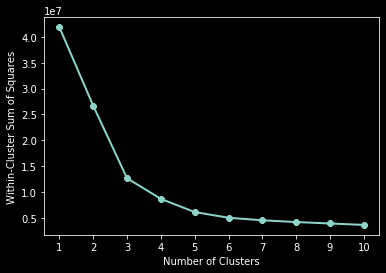

In [22]:
# clustering with baseline features

wcss = []
# scores = []
for k in np.arange(1,11):
#     kmeans = KMeans(n_clusters=k, init="k-means++").fit(scaled_df)
#     dump(kmeans, f'../data/{k}_means_cluster.pkl')
    kmeans = load(f'../data/{k}_means_cluster.pkl')
    wcss.append(kmeans.inertia_)
#     if k >= 2:
#         scores.append([silhouette_score(
#             scaled_df, kmeans.predict(scaled_df), random_state=0), k])

# dump(scores, '../data/k_means_cluster_scores.pkl')

scores = load('../data/k_means_cluster_scores.pkl')

for score in scores:
    print(f'For {score[1]} clusters,',
          f'the average silhouette score is: {score[0]}')

plt.plot(np.arange(1,11), wcss, linewidth=2, marker='8')
plt.xticks(np.arange(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()